# Gradient Tape with Tensorflow - MNIST - Functional API

In this notebook, we look at an example of training a Tensorflow model using Gradient Tape
To run this notebook, I am using the following package versions:

* Tensorflow: 2.8.0

* OpenCV: 4.6.0

* Tensorflow datasets: 4.6.0

There might be minor variations in the code for different versions of these packages.

Also this implementation assumes some knowledge of Tensorflow Functional API. 

### Import necessary packages

In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import matplotlib.ticker as mticker


### Load, split and understand the dataset

Under this section we load the dateset from tensorflow datasets and split the data into **train** and **test**. For more information on how the split is performed check out this link: https://github.com/tensorflow/datasets/blob/master/docs/splits.md

Once we have performed the split we want to get a bit more information on how the data is stored after loading. Understanding the datatype beforehand cause prevent a lot of issues from occuring later. 

In [2]:
train_data, info = tfds.load("mnist", split = "train", with_info = True)
test_data = tfds.load("mnist", split = "test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\mnist\3.0.1.incomplete7Y0TW5\mnist-train.tfrecord*...:   0%|          | 0/6000…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\mnist\3.0.1.incomplete7Y0TW5\mnist-test.tfrecord*...:   0%|          | 0/10000…

Dataset mnist downloaded and prepared to ~\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [3]:
train_data

<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [4]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [5]:
num_classes = info.features["label"].num_classes
num_classes

10

In [6]:
class_names = info.features["label"].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

### Data formatting 

We have seen earlier that the images are of size 28*28. Here we format the images such that it can be consumed in the input layer of our model. For the sake of understanding, we will create a dummy tensor with the same shape as the input image, pass it through the formatting function and understand the dimensions of the input to the model

In [7]:
def format_image(data):
    """
       Function to reshape, format and normalize input images to make it compatible with the deep learning model
       Inputs:
       data: Input image
       Outputs:
       image: Formatted image
       data["label"]: Training label associated with the image
    """
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [8]:
dummy_tensor=tf.ones([28, 28,1], tf.int32)*255

In [9]:
dummy_dict={"image":dummy_tensor, "label":1}

In [10]:
formatted_dummy=format_image(dummy_dict)

In [11]:
formatted_dummy[0].shape

TensorShape([784])

If you have any issues understanding the different stages of the function you can add print statments after each step. Remember to remove/comment them out before going to the next cell though!!

Now lets apply the ***format_image*** function on the entire train and test dataset

In [12]:
batch_size = 64

train_data = train_data.map(format_image)
test_data = test_data.map(format_image)
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test =  test_data.batch(batch_size=batch_size)

### Define the model

In [13]:
### Define the model,
def base_model():
    """
    Define the model architecture here
    """
    inputs = tf.keras.Input(shape=(784,), name='digits')
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
#Define Optimizer and Loss Function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [15]:
#Define Metrics 
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

### Define the training loop

In [16]:
def apply_gradient(optimizer, model, x, y):
    """
    Function for computing gradient and updating the weights
    """
    with tf.GradientTape() as tape:
        # Get model prediction and compute the loss
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)
    # Calculate the gradient using tape.gradient and then update the model weights using our optimizer
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))  
    return logits, loss_value

In [17]:
def train_data_for_one_epoch():
    """
    Function for computing the gradient and updating weights in each epoch. 
    """
    losses = []
    # Iterate over batches of the dataset and call apply_gradient function
    for step, (x_batch_train, y_batch_train) in enumerate(train):
        logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)     
        losses.append(loss_value)
        train_acc_metric(y_batch_train, logits)
    return losses


In [18]:
def perform_validation():
    """
    Function for validation
    """
    losses = []
    for x_val, y_val in test:
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)
        val_acc_metric(y_val, val_logits)
    return losses

### Model training

In [19]:
model = base_model()

# Iterate over epochs
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    #Perform training using gradient tape
    losses_train = train_data_for_one_epoch()
    train_acc = train_acc_metric.result()
    
    #Perform validation
    losses_val = perform_validation()
    val_acc = val_acc_metric.result()
    
    #Compute mean training and validation loss in the epoch 
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0

 Epoch 0: Train loss: 0.3165  Validation Loss: 0.1763, Train Accuracy: 0.9097, Validation Accuracy 0.9465
Start of epoch 1

 Epoch 1: Train loss: 0.1423  Validation Loss: 0.1180, Train Accuracy: 0.9579, Validation Accuracy 0.9649
Start of epoch 2

 Epoch 2: Train loss: 0.1047  Validation Loss: 0.1030, Train Accuracy: 0.9695, Validation Accuracy 0.9700
Start of epoch 3

 Epoch 3: Train loss: 0.0830  Validation Loss: 0.0953, Train Accuracy: 0.9751, Validation Accuracy 0.9710
Start of epoch 4

 Epoch 4: Train loss: 0.0672  Validation Loss: 0.0925, Train Accuracy: 0.9804, Validation Accuracy 0.9729
Start of epoch 5

 Epoch 5: Train loss: 0.0563  Validation Loss: 0.0868, Train Accuracy: 0.9830, Validation Accuracy 0.9739
Start of epoch 6

 Epoch 6: Train loss: 0.0482  Validation Loss: 0.0946, Train Accuracy: 0.9848, Validation Accuracy 0.9722
Start of epoch 7

 Epoch 7: Train loss: 0.0400  Validation Loss: 0.0955, Train Accuracy: 0.9877, Validation Accuracy 0.9727
Start of

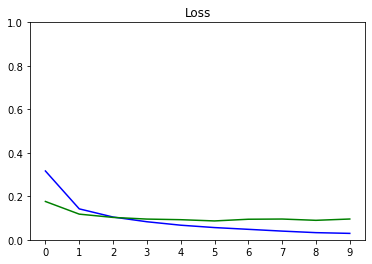

In [20]:
#Plots for Evaluation
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)